In [1]:
from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

In [2]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.1.106:37487 Dashboard: /user/0000-0001-7783-5629/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import sys, glob
import numpy as np
import xarray as xr
import xscale.spectral.fft as xfft
import xscale 
import Wavenum_freq_spec_func as wfs
import time

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
from matplotlib.colors import LogNorm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic


In [5]:
%%time
import gcsfs

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')

gcsmapgridu=gcsfs.mapping.GCSMap('pangeo-data/NATL60-CJM165-SSU-1h-1m2deg2deg',gcs=fs,check=False,create=False)
dsu=xr.open_zarr(gcsmapgridu)

gcsmapgridv=gcsfs.mapping.GCSMap('pangeo-data/NATL60-CJM165-SSV-1h-1m2deg2deg',gcs=fs,check=False,create=False)
dsv=xr.open_zarr(gcsmapgridv)


CPU times: user 48.7 s, sys: 6.46 s, total: 55.2 s
Wall time: 4min 6s


In [54]:
dsu.vozocrtx[6552:]

<xarray.DataArray 'vozocrtx' (time_counter: 2208, y: 3454, x: 5422)>
dask.array<shape=(2208, 3454, 5422), dtype=float32, chunksize=(24, 120, 120)>
Coordinates:
    nav_lat        (y, x) float32 dask.array<shape=(3454, 5422), chunksize=(432, 678)>
    nav_lon        (y, x) float32 dask.array<shape=(3454, 5422), chunksize=(432, 678)>
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(2208,), chunksize=(144,)>
  * time_counter   (time_counter) datetime64[ns] 2013-07-01T00:30:00 ... 2013-09-30T23:30:00
Dimensions without coordinates: y, x
Attributes:
    cell_methods:        time: mean (interval: 40 s)
    interval_operation:  40 s
    interval_write:      1 h
    long_name:           ocean surface current along i-axis
    online_operation:    average
    units:               m/s

In [6]:
%%time
lat=dsu['nav_lat']
lon=dsu['nav_lon']
 
latmin = 40.0; latmax = 45.0;
lonmin = -40.0; lonmax = -35.0;

domain = (lonmin<lon) * (lon<lonmax) * (latmin<lat) * (lat<latmax)
where = np.where(domain)

#get indice
jmin = np.min(where[0][:])
jmax = np.max(where[0][:])
imin = np.min(where[1][:])
imax = np.max(where[1][:])

latbox=lat[jmin:jmax,imin:imax]
lonbox=lon[jmin:jmax,imin:imax]


CPU times: user 1.39 s, sys: 217 ms, total: 1.61 s
Wall time: 4.81 s


In [7]:
%%time

print('Select dates')
u_JFM=dsu.sel(time_counter=slice('2013-01-01','2013-03-31'))['vozocrtx']
v_JFM=dsv.sel(time_counter=slice('2013-01-01','2013-03-31'))['vomecrty']

print('Select box area')
u_JFM_box=u_JFM[:,jmin:jmax,imin:imax]
v_JFM_box=v_JFM[:,jmin:jmax,imin:imax]


# - get dx and dy
print('get dx and dy')
dx_JFM,dy_JFM = wfs.get_dx_dy(u_JFM_box[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JFM = wfs.detrendn(u_JFM_box,axes=[0,1,2])
v_JFM = wfs.detrendn(v_JFM_box,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JFM = wfs.apply_window(u_JFM, u_JFM.dims, window_type='hanning')
v_JFM = wfs.apply_window(v_JFM, v_JFM.dims, window_type='hanning')


#... Apply hanning windowing ...') 
print('FFT ')
u_JFMhat = xfft.fft(u_JFM, dim=('time_counter', 'x', 'y'), dx={'x': dx_JFM, 'y': dx_JFM}, sym=True)
v_JFMhat = xfft.fft(v_JFM, dim=('time_counter', 'x', 'y'), dx={'x': dx_JFM, 'y': dx_JFM}, sym=True)

#... Apply hanning windowing ...') 
print('PSD ')
u_JFM_psd = xfft.psd(u_JFMhat)
v_JFM_psd = xfft.psd(v_JFMhat)


#... Get frequency and wavenumber ... 
print('Get frequency and wavenumber')
frequency_JFM = u_JFMhat.f_time_counter
kx_JFM = u_JFMhat.f_x
ky_JFM = u_JFMhat.f_y

#... Get istropic wavenumber ... 
print('Get istropic wavenumber')
wavenumber_JFM,kradial_JFM = wfs.get_wavnum_kradial(kx_JFM,ky_JFM)

#... Get numpy array ... 
print('Get numpy array')
u_JFM_psd_np = u_JFM_psd.values
v_JFM_psd_np = v_JFM_psd.values

#... Get 2D frequency-wavenumber field ... 
print('Get f k in 2D')
u_JFM_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JFM,wavenumber_JFM,u_JFM_psd_np)
v_JFM_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JFM,wavenumber_JFM,v_JFM_psd_np)

KE_JFM_wavenum_freq_spectrum=0.5*(u_JFM_wavenum_freq_spectrum+v_JFM_wavenum_freq_spectrum)


Select dates
Select box area
get dx and dy
Detrend data in all dimension
Apply hanning windowing
FFT 
PSD 
Get frequency and wavenumber
Get istropic wavenumber
Get numpy array


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 27920 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 27918 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 27919 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Get f k in 2D
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
CPU times: user 15min 33s, sys: 1min 8s, total: 16min 42s
Wall time: 21min 35s


In [8]:
# Save to Netscdf file
# - build dataarray
print('Save to Netscdf file')
KE_JFM_wavenum_freq_spectrum_da = xr.DataArray(KE_JFM_wavenum_freq_spectrum,dims=['frequency','wavenumber'],name="Ke_spectrum",coords=[frequency_JFM ,wavenumber_JFM])
KE_JFM_wavenum_freq_spectrum_da.attrs['Name'] = 'KE_Spectrum_JFM_w_k_from_1h_NATL60-CJM165.nc'

KE_JFM_wavenum_freq_spectrum_da.to_dataset().to_netcdf(path='/mnt/alberta/equipes/IGE/meom/workdir/albert/NATL60/NATL60-CJM165-S/1h/KE_Spectrum_JFM_w_k_from_1h_NATL60-CJM165.nc',mode='w',engine='scipy')


Save to Netscdf file


In [7]:
%%time



print('Select box area')
u_JAS_box=dsu.vozocrtx[6552:,jmin:jmax,imin:imax].chunk({'time_counter':1,'x':120,'y':120})
v_JAS_box=dsv.vomecrty[6552:,jmin:jmax,imin:imax].chunk({'time_counter':1,'x':120,'y':120})

# - get dx and dy
print('get dx and dy')
dx_JAS,dy_JAS = wfs.get_dx_dy(u_JAS_box[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JAS = wfs.detrendn(u_JAS_box,axes=[0,1,2])
v_JAS = wfs.detrendn(v_JAS_box,axes=[0,1,2])

Select box area
get dx and dy
Detrend data in all dimension
CPU times: user 3min 18s, sys: 1min 9s, total: 4min 27s
Wall time: 3min 47s


In [8]:
u_JAS_box

<xarray.DataArray 'vozocrtx' (time_counter: 2208, y: 401, x: 302)>
dask.array<shape=(2208, 401, 302), dtype=float32, chunksize=(1, 120, 120)>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2013-07-01T00:30:00 ... 2013-09-30T23:30:00
Dimensions without coordinates: y, x
Attributes:
    cell_methods:        time: mean (interval: 40 s)
    coordinates:         nav_lat time_centered nav_lon
    interval_operation:  40 s
    interval_write:      1 h
    long_name:           ocean surface current along i-axis
    online_operation:    average
    units:               m/s

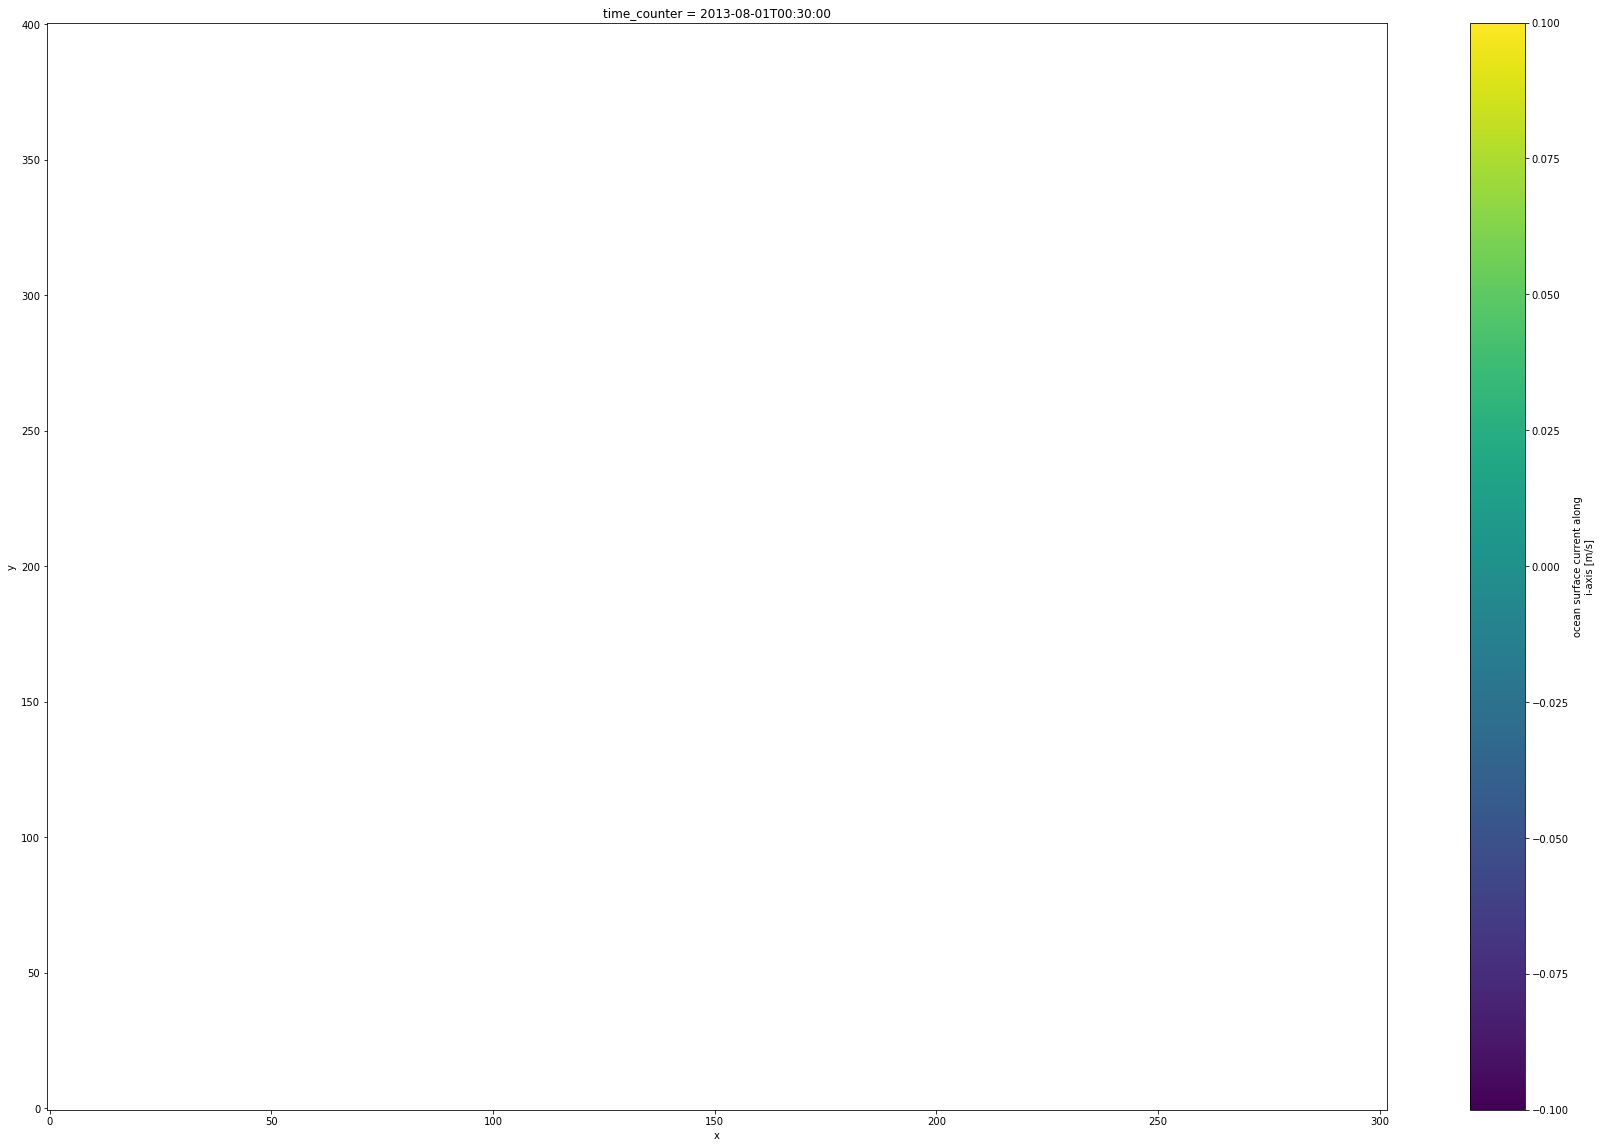

In [9]:
fig=plt.figure(figsize=(30,20))

u_JAS_box[744].plot()

In [35]:
where = np.where(np.isnan(u_JAS_box.values)==True)


distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)


In [38]:
print(where[0][0])

744


In [11]:
%%time

print('Select dates')
u_JAS=dsu.sel(time_counter=slice('2013-07-01','2013-09-28'))['vozocrtx']
v_JAS=dsv.sel(time_counter=slice('2013-07-01','2013-09-28'))['vomecrty']

print('Select box area')
u_JAS_box=u_JAS[:,jmin:jmax,imin:imax].chunk({'time_counter':1,'x':120,'y':120})
v_JAS_box=v_JAS[:,jmin:jmax,imin:imax].chunk({'time_counter':1,'x':120,'y':120})


# - get dx and dy
print('get dx and dy')
dx_JAS,dy_JAS = wfs.get_dx_dy(u_JAS_box[0],lonbox,latbox)


#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JAS = wfs.detrendn(u_JAS_box,axes=[0,1,2])
v_JAS = wfs.detrendn(v_JAS_box,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JAS = wfs.apply_window(u_JAS, u_JAS.dims, window_type='hanning')
v_JAS = wfs.apply_window(v_JAS, v_JAS.dims, window_type='hanning')


#... Apply hanning windowing ...') 
print('FFT ')
u_JAShat = xfft.fft(u_JAS, dim=('time_counter', 'x', 'y'), dx={'x': dx_JAS, 'y': dx_JAS}, sym=True)
v_JAShat = xfft.fft(v_JAS, dim=('time_counter', 'x', 'y'), dx={'x': dx_JAS, 'y': dx_JAS}, sym=True)

#... Apply hanning windowing ...') 
print('PSD ')
u_JAS_psd = xfft.psd(u_JAShat)
v_JAS_psd = xfft.psd(v_JAShat)


#... Get frequency and wavenumber ... 
print('Get frequency and wavenumber')
frequency_JAS = u_JAShat.f_time_counter
kx_JAS = u_JAShat.f_x
ky_JAS = u_JAShat.f_y

#... Get istropic wavenumber ... 
print('Get istropic wavenumber')
wavenumber_JAS,kradial_JAS = wfs.get_wavnum_kradial(kx_JAS,ky_JAS)

#... Get numpy array ... 
print('Get numpy array')
u_JAS_psd_np = u_JAS_psd.values
v_JAS_psd_np = v_JAS_psd.values

#... Get 2D frequency-wavenumber field ... 
print('Get f k in 2D')
u_JAS_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,u_JAS_psd_np)
v_JAS_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,v_JAS_psd_np)

KE_JAS_wavenum_freq_spectrum=0.5*(u_JAS_wavenum_freq_spectrum+v_JAS_wavenum_freq_spectrum)


Select dates
Select box area
get dx and dy
Detrend data in all dimension


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Apply hanning windowing
FFT 


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


PSD 
Get frequency and wavenumber
Get istropic wavenumber
Get numpy array


distributed.utils - ERROR - Worker already exists tcp://10.32.2.4:46645
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/distributed/scheduler.py", line 1410, in add_worker
    raise ValueError("Worker already exists %s" % address)
ValueError: Worker already exists tcp://10.32.2.4:46645
distributed.core - ERROR - Worker already exists tcp://10.32.2.4:46645
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/distributed/core.py", line 412, in handle_comm
    result = yield result
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/srv/conda/envs/notebook/lib/python3.6/site-packa

Get f k in 2D
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
CPU times: user 34min 10s, sys: 3min 52s, total: 38min 3s
Wall time: 36min 12s


In [12]:
# Save to Netscdf file
# - build dataarray
print('Save to Netscdf file')
KE_JAS_wavenum_freq_spectrum_da = xr.DataArray(KE_JAS_wavenum_freq_spectrum,dims=['frequency','wavenumber'],name="Ke_spectrum",coords=[frequency_JAS ,wavenumber_JAS])
KE_JAS_wavenum_freq_spectrum_da.attrs['Name'] = 'KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc'

KE_JAS_wavenum_freq_spectrum_da.to_dataset().to_netcdf(path='KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc',mode='w',engine='scipy')


Save to Netscdf file


/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
/srv/conda/envs/notebook/lib/python3.6/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


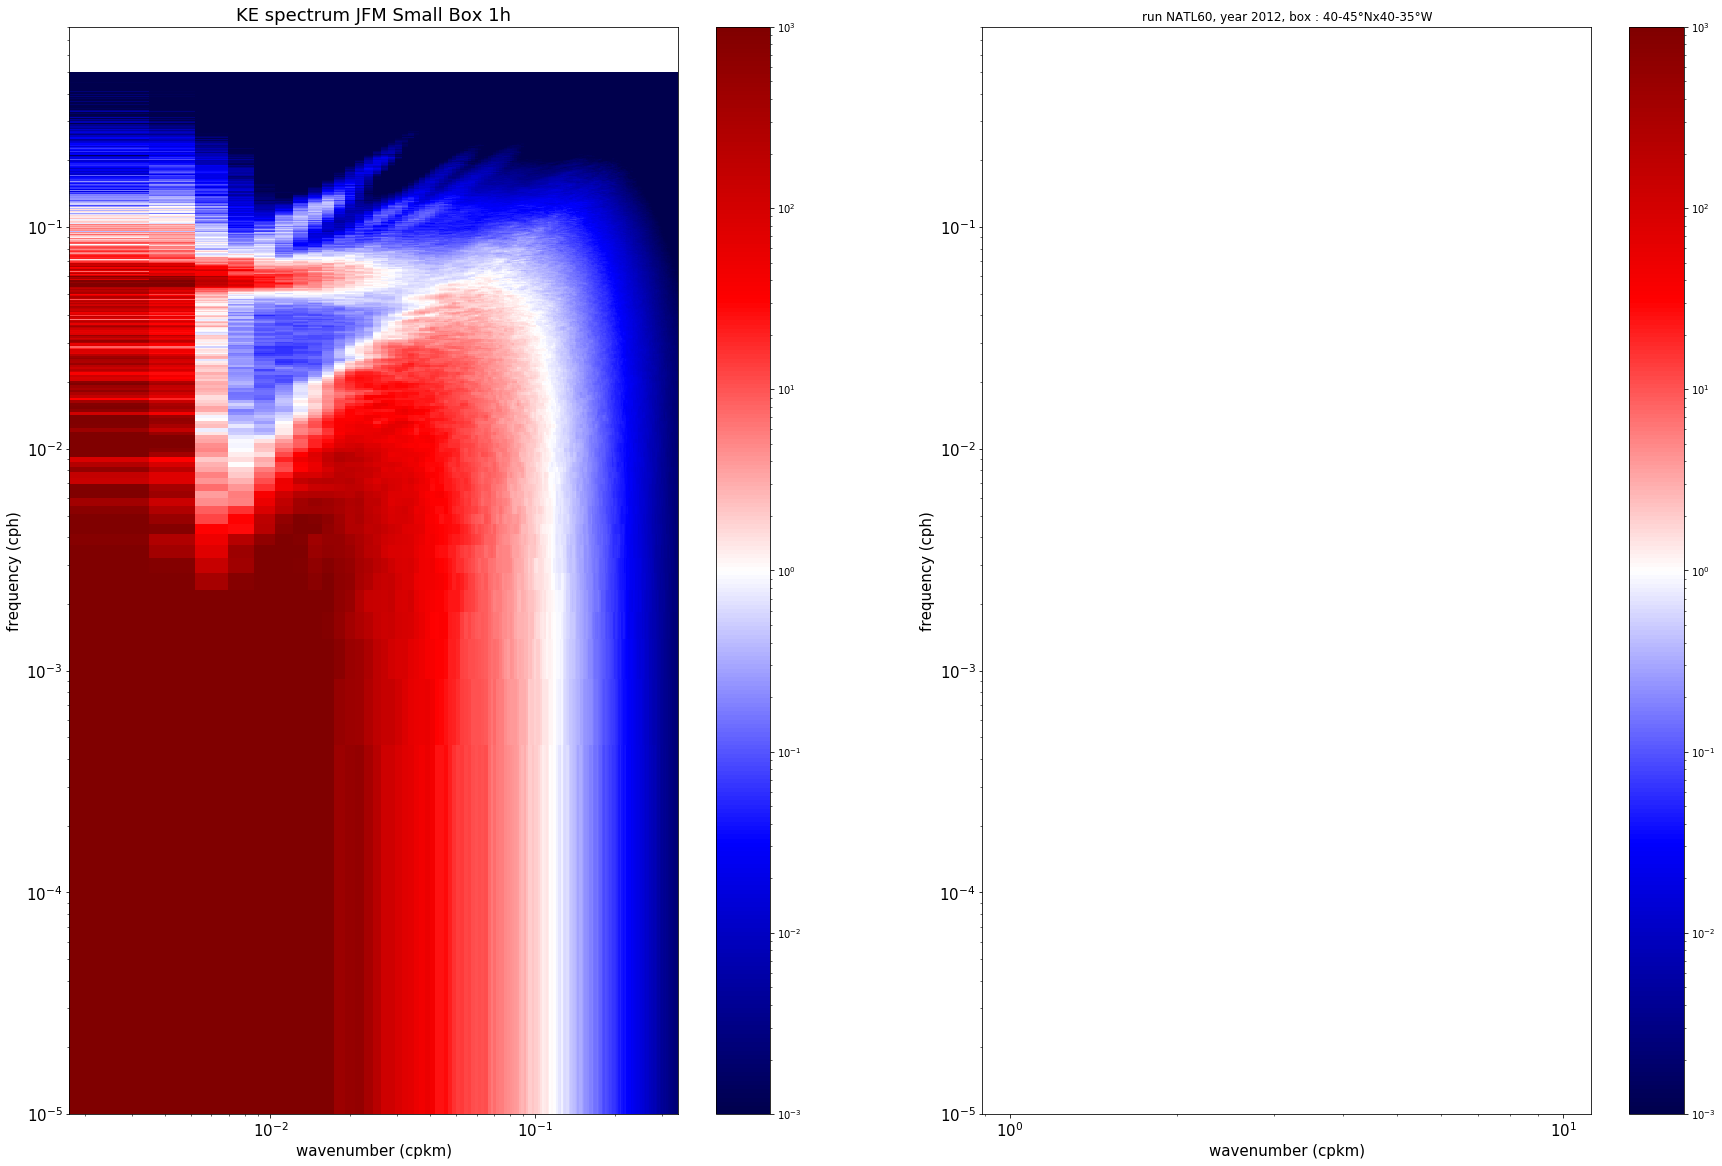

In [13]:
ds_JFM=xr.open_dataset('KE_Spectrum_JFM_w_k_from_1h_NATL60-CJM165.nc')
ds_JAS=xr.open_dataset('KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc')

wavenumber_JFM=ds_JFM['wavenumber']
frequency_JFM=ds_JFM['frequency']
KE_JFM_wavenum_freq_spectrum=ds_JFM['Ke_spectrum']

wavenumber_JAS=ds_JAS['wavenumber']
frequency_JAS=ds_JAS['frequency']
KE_JAS_wavenum_freq_spectrum=ds_JAS['Ke_spectrum']


sec_to_hour = 3600.0
norm = LogNorm(vmin=0.001,vmax=1000)
cmap = div_cmap

fig=plt.figure(figsize=(30,20))

ax = plt.subplot(121)
plt.pcolormesh(wavenumber_JFM,sec_to_hour*frequency_JFM,KE_JFM_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JFM.min(),wavenumber_JFM.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE spectrum JFM Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

ax = plt.subplot(122)
plt.pcolormesh(wavenumber_JAS,sec_to_hour*frequency_JAS,KE_JAS_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JAS.min(),wavenumber_JAS.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE spectrum JAS Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

plt.title('run NATL60, year 2012, box : 40-45°Nx40-35°W')
plt.savefig('KE_spectrum_NATL60_JFM-JAS_smallbox.png')